# **Fraud Detection in Financial Transactions**

---

## Introduction
This notebook aims to develop a predictive model to identify fraudulent transactions for a financial company.  
We use the dataset with 6,362,620 rows and 10 columns.  
The goal is to detect fraud proactively and provide actionable recommendations.  


In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, make_scorer, f1_score
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import joblib
from sklearn.metrics import make_scorer, recall_score

---

## Data Loading & Cleaning
- Load CSV dataset.
- Handle missing values-but this dataset doesn't contain any missing values
-Duplicates handling-no duplicates found
- Verify data types and ensure consistency.

In [5]:
df=pd.read_csv("Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [6]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600612 entries, 0 to 600611
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            600612 non-null  int64  
 1   type            600612 non-null  object 
 2   amount          600612 non-null  float64
 3   nameOrig        600612 non-null  object 
 4   oldbalanceOrg   600611 non-null  float64
 5   newbalanceOrig  600611 non-null  float64
 6   nameDest        600611 non-null  object 
 7   oldbalanceDest  600611 non-null  float64
 8   newbalanceDest  600611 non-null  float64
 9   isFraud         600611 non-null  float64
 10  isFlaggedFraud  600611 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 50.4+ MB


In [8]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,1
newbalanceOrig,1
nameDest,1
oldbalanceDest,1
newbalanceDest,1
isFraud,1


In [9]:
df.duplicated().sum()


np.int64(0)

In [10]:
df.describe()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,600612.000000,6.006120e+05,6.006110e+05,6.006110e+05,6.006110e+05,6.006110e+05,600611.000000,600611.0
mean,15.598055,1.610872e+05,8.872377e+05,9.070328e+05,9.731477e+05,1.136360e+06,0.000601,0.0
std,5.510990,2.691434e+05,2.953876e+06,2.990929e+06,2.315647e+06,2.473727e+06,0.024509,0.0
min,1.000000,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,12.000000,1.231929e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,15.000000,7.549022e+04,1.777800e+04,0.000000e+00,1.125947e+05,2.056730e+05,0.000000,0.0
75%,19.000000,2.150657e+05,1.567248e+05,1.955816e+05,8.897624e+05,1.168700e+06,0.000000,0.0
max,34.000000,1.000000e+07,3.893942e+07,3.894623e+07,4.148270e+07,4.148270e+07,1.000000,0.0


Transactions are spread across millions of accounts.

Senders are mostly unique (like customers making transactions once).

Receivers repeat more often (like companies or fraudsters receiving money from many).

The most common transaction type is CASH_OUT.


In [11]:
df.describe(include=['object'])


,type,nameOrig,nameDest
count,600612,600612,600611
unique,5,600530,260779
top,CASH_OUT,C745009740,C985934102
freq,212996,2,95


In [12]:
df["isFraud"].value_counts()

,count
isFraud,
0.0,600250
1.0,361


In [13]:

df["isFraud"].value_counts(normalize=True) * 100

,proportion
isFraud,
0.0,99.939895
1.0,0.060105


## Exploratory Data Analysis (EDA)
-Outlier analysis and multicollinearity detection
-Analyze class distribution (fraud vs non-fraud).

-Visualize feature distributions using histograms and boxplots.

-Explore bivariate relationships between features and target.

-Correlation analysis and pairplots to identify patterns.

-Insights derived from EDA for fraud detection.

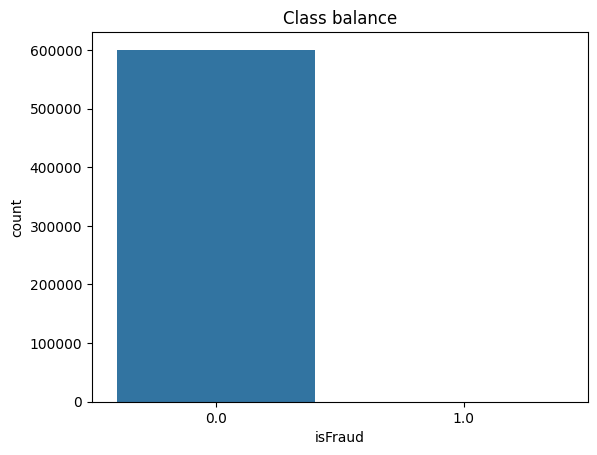

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.countplot(x='isFraud', data=df)
ax.set_title('Class balance')
plt.show()

This count plot for isFraud shows a highly imbalanced dataset: the vast majority of transactions are non-fraudulent (0), while fraudulent transactions (1) are extremely rare.

Implications:
Training a model without addressing this imbalance can lead to poor detection of fraud. A naive model predicting all transactions as non-fraud would achieve high accuracy but fail on the minority class, making metrics like recall and F1-score crucial.

type
TRANSFER    0.003573
CASH_OUT    0.000873
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64


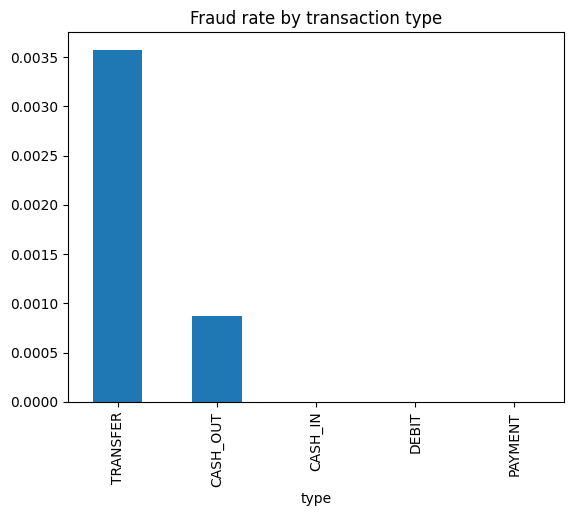

In [15]:
#Checking if certain types of transactions are more prone to fraud.
fraud_rate_by_type = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
print(fraud_rate_by_type)
fraud_rate_by_type.plot(kind='bar')
plt.title('Fraud rate by transaction type')
plt.show()

TRANSFER and CASH_OUT are the primary sources of fraud.

In [16]:
pivot_table_analysis = df.pivot_table(
    index='type',
    values='isFraud',
    aggfunc=['count', 'mean'],
    margins=True
)
pivot_table_analysis.columns = ['Count of Transactions', 'Fraud Rate']
pivot_table_analysis['Fraud Rate'] = pivot_table_analysis['Fraud Rate'] * 100
print(pivot_table_analysis)

          Count of Transactions  Fraud Rate
type                                       
CASH_IN                  130173    0.000000
CASH_OUT                 212996    0.087326
DEBIT                      4621    0.000000
PAYMENT                  203841    0.000000
TRANSFER                  48980    0.357289
All                      600611    0.060105


In [17]:
pivot_table_analysis = df.pivot_table(
    index='type',
    values=['isFraud', 'amount', 'isFlaggedFraud'],
    aggfunc=['mean', 'std'],
    margins=True
)

# Create a color map for the gradient
cm = sns.light_palette("blue", as_cmap=True)

# Apply the gradient styling to the table
styled_table = pivot_table_analysis.style.background_gradient(cmap=cm)

# To display the styled table, you must run this line in a notebook environment
styled_table

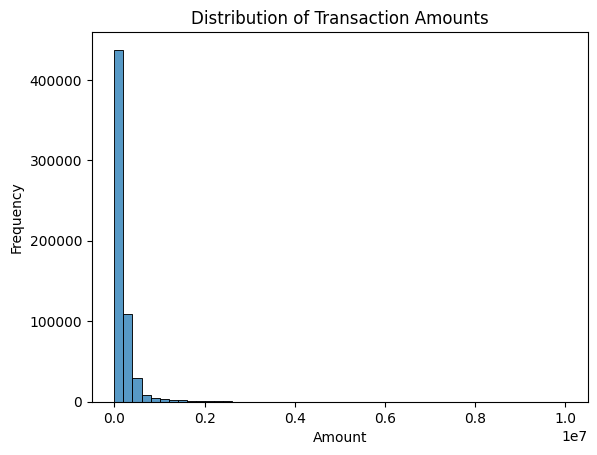

In [18]:
sns.histplot(data=df, x='amount', bins=50)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

Large number of outliers identified

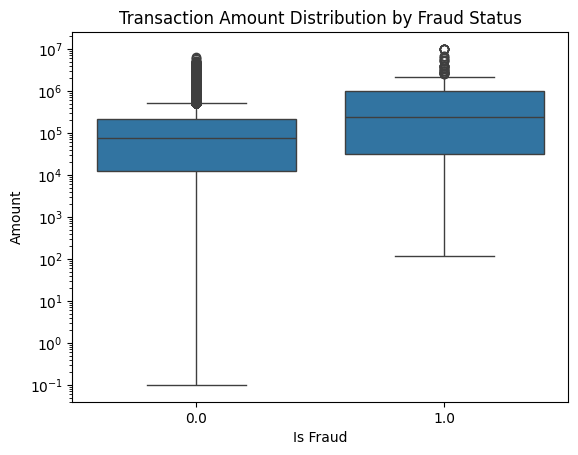

In [19]:
# box plot to compare the distribution of amounts
# for fraudulent (1) vs. non-fraudulent (0) transactions
sns.boxplot(x='isFraud', y='amount', data=df)

plt.title('Transaction Amount Distribution by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Amount')
plt.yscale('log') # Use a log scale due to the high skew
plt.show()

In [20]:
contingency_table = pd.crosstab(df['isFlaggedFraud'], df['isFraud'])
styled_table = contingency_table.style.background_gradient(
    cmap=sns.light_palette("green", as_cmap=True)
).format('{:,}')

styled_table

isFraud,0.000000,1.000000
isFlaggedFraud,,
0.000000,"600,250",361


The contingency table shows the relationship between isFraud and isFlaggedFraud. It indicates, for actual fraudulent transactions (isFraud = 1), how many were correctly flagged (isFlaggedFraud = 1).

Top-left (600,250): Transactions that are not fraud and were not flagged – correct negatives.

Top-right (361): Transactions that are fraudulent but not flagged – false negatives (missed frauds).

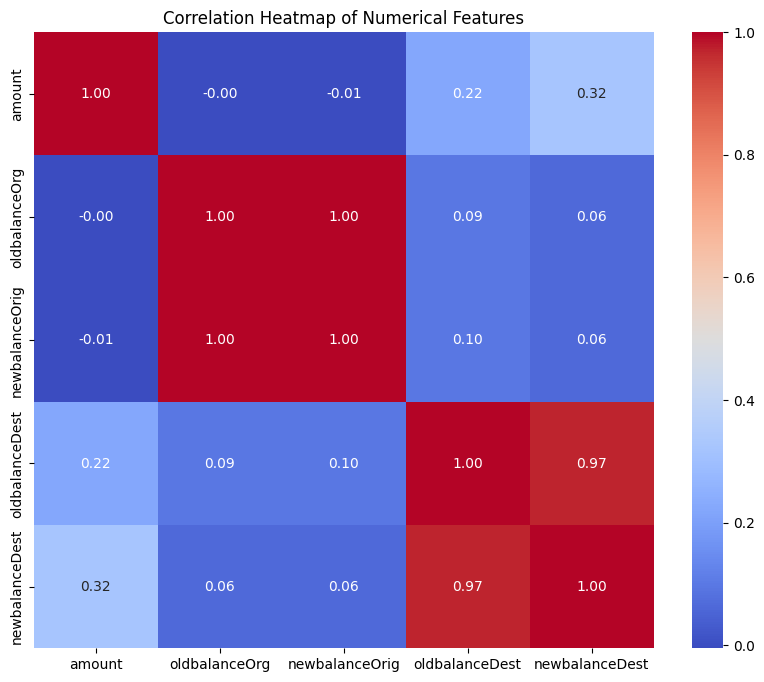

In [21]:
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Create the correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Create a heatmap to visualize the correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

Features that are having multicollinearity are:


*   oldbalanceOrg vs newbalanceOrg
*   oldbalanceDest vs newbalanceDest




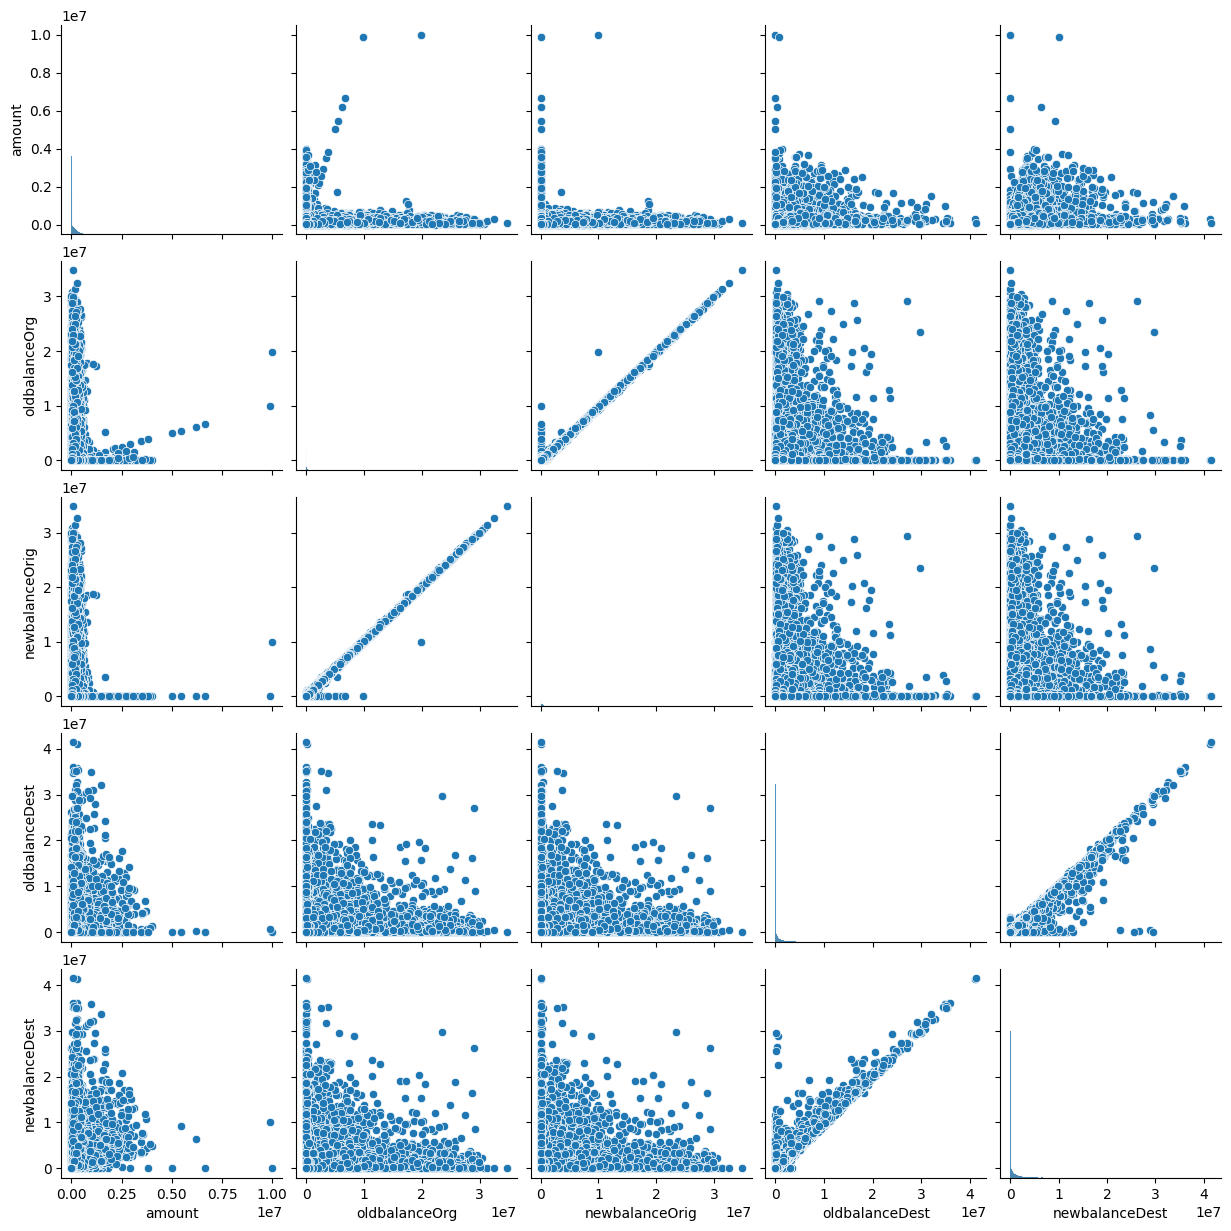

In [22]:
# Take a random sample of the data (e.g., 50,000 rows)
sample_df = df.sample(n=50000, random_state=42)

# Select the numerical columns you want to visualize
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Create the pair plot using the sampled data
sns.pairplot(sample_df[numerical_cols])

# Display the plot
plt.show()

In [23]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


## Feature Engineering & Selection

* Encode categorical features.

* Create additional features that might help model performance.

* Handle class imbalance using SMOTE

* Split dataset into training and testing sets.

In [24]:
df_feat = df.copy()
df_feat.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [25]:
# time features
df_feat['day']  = (df_feat['step'] // 24).astype(int)
df_feat['hour'] = (df_feat['step'] % 24).astype(int)

In [26]:
# transaction type flags
df_feat['is_cash_in']  = (df_feat['type'] == 'CASH_IN').astype(int)
df_feat['is_cash_out'] = (df_feat['type'] == 'CASH_OUT').astype(int)
df_feat['is_debit']    = (df_feat['type'] == 'DEBIT').astype(int)
df_feat['is_payment']  = (df_feat['type'] == 'PAYMENT').astype(int)
df_feat['is_transfer'] = (df_feat['type'] == 'TRANSFER').astype(int)

In [27]:
# merchant destination (dest starts with 'M')
df_feat['is_merchant_dest'] = df_feat['nameDest'].str.startswith('M').fillna(False).astype(int)

/tmp/ipython-input-3844540887.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_feat['is_merchant_dest'] = df_feat['nameDest'].str.startswith('M').fillna(False).astype(int)


In [28]:
# error-based features: how much balances deviate
df_feat['orig_txn_diff'] = df_feat['newbalanceOrig'] + df_feat['amount'] - df_feat['oldbalanceOrg']
df_feat['dest_txn_diff'] = df_feat['oldbalanceDest'] + df_feat['amount'] - df_feat['newbalanceDest']

In [29]:
# binary indicators: whether there is any inconsistency
df_feat['orig_diff_flag'] = (df_feat['orig_txn_diff'] != 0).astype(int)
df_feat['dest_diff_flag'] = (df_feat['dest_txn_diff'] != 0).astype(int)

It creates meaningful ratios. By calculating amt_over_oldorg, it tells your model what percentage of a person's balance was used in a transaction, which is a much stronger signal for fraud than the raw amount or balance alone.

It cleans up the data. The log_amount transformation makes the data more normal, helping your model ignore extreme values and focus on the overall patterns. This is crucial for building a reliable model.

In [30]:
eps = 1e-9
df_feat['amt_over_oldorg']  = df_feat['amount'] / (df_feat['oldbalanceOrg'] + eps)
df_feat['amt_over_olddest'] = df_feat['amount'] / (df_feat['oldbalanceDest'] + eps)
df_feat['log_amount'] = np.log1p(df_feat['amount'])

Removing Redundant features

In [31]:
# drop raw ID columns (not useful as features)
df_feat = df_feat.drop(columns=['nameOrig','nameDest','type','step'], errors='ignore')

# fill inf/nans (from division when denom 0)
df_feat.replace([np.inf, -np.inf], np.nan, inplace=True)
df_feat.fillna(0, inplace=True)

In [32]:
df_feat.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day,hour,is_cash_in,...,is_payment,is_transfer,is_merchant_dest,orig_txn_diff,dest_txn_diff,orig_diff_flag,dest_diff_flag,amt_over_oldorg,amt_over_olddest,log_amount
0,9839.64,170136.0,160296.36,0.0,0.0,0.0,0.0,0,1,0,...,1,0,1,0.0,9839.64,0,1,0.057834,9.839640e+12,9.194276
1,1864.28,21249.0,19384.72,0.0,0.0,0.0,0.0,0,1,0,...,1,0,1,0.0,1864.28,0,1,0.087735,1.864280e+12,7.531166
2,181.00,181.0,0.00,0.0,0.0,1.0,0.0,0,1,0,...,0,1,0,0.0,181.00,0,1,1.000000,1.810000e+11,5.204007
3,181.00,181.0,0.00,21182.0,0.0,1.0,0.0,0,1,0,...,0,0,0,0.0,21363.00,0,1,1.000000,8.544991e-03,5.204007
4,11668.14,41554.0,29885.86,0.0,0.0,0.0,0.0,0,1,0,...,1,0,1,0.0,11668.14,0,1,0.280795,1.166814e+13,9.364703


SMOTE Analysis and Splitting of Data For Training

In [33]:
from imblearn.over_sampling import SMOTE

# -----------------------
# 1. Separate features and target
# -----------------------
X = df_feat.drop(columns=['isFraud'])   # Features
y = df_feat['isFraud']                  # Target

# -----------------------
# 2. Split into train & test
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Before SMOTE:")
print(y_train.value_counts())

# -----------------------
# 3. Apply SMOTE on training set only
# -----------------------
smote = SMOTE(random_state=42, k_neighbors=5)  # k=5 default, can tune
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(y_train_smote.value_counts())

# -----------------------
# 4. Confirm shape
# -----------------------
print("\nShapes:")
print("X_train_smote:", X_train_smote.shape)
print("y_train_smote:", y_train_smote.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Before SMOTE:
isFraud
0.0    480200
1.0       289
Name: count, dtype: int64

After SMOTE:
isFraud
0.0    480200
1.0    480200
Name: count, dtype: int64

Shapes:
X_train_smote: (960400, 21)
y_train_smote: (960400,)
X_test: (120123, 21)
y_test: (120123,)


## Model Building

* Select candidate models: Logistic Regression,, Random Forest, Decision Tree, XGBoost, AdaBoost, Naive Bayes

* Select the best-performing model based on Recall, F1-score, and ROC-AUC.

In [34]:
# -----------------------------
# Define models
# -----------------------------
models = {
    "LogisticRegression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "RandomForest": RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "DecisionTree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42),
    "NaiveBayes": GaussianNB()
}

# -----------------------------
# Determine minority class
# -----------------------------
fraud_class = y_test.value_counts().idxmin()  # dynamically picks minority class (1.0)

# -----------------------------
# Train, Predict, Evaluate
# -----------------------------
results = []

for name, model in models.items():
    print(f"\n========== Model: {name} ==========")
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        y_proba = model.decision_function(X_test)

    # Classification report
    report = classification_report(y_test, y_pred)
    print(report)

    # ROC-AUC
    roc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC Score: {roc:.4f}")

    # Use output_dict with string keys
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    # Convert keys to float safely
    report_dict_float = {float(k): v for k,v in report_dict.items() if k.replace('.','',1).isdigit()}

    results.append({
        "Model": name,
        "F1_Fraud": report_dict_float[fraud_class]['f1-score'],
        "Recall_Fraud": report_dict_float[fraud_class]['recall'],
        "Precision_Fraud": report_dict_float[fraud_class]['precision'],
        "ROC-AUC": roc
    })

# -----------------------------
# Create results dataframe
# -----------------------------
results_df = pd.DataFrame(results).sort_values(by='F1_Fraud', ascending=False)
print("\n===== Summary of all models =====")
print(results_df)



========== Model: LogisticRegression ==========
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80    120051
         1.0       0.00      0.75      0.00        72

    accuracy                           0.67    120123
   macro avg       0.50      0.71      0.40    120123
weighted avg       1.00      0.67      0.80    120123

ROC-AUC Score: 0.8160

========== Model: RandomForest ==========
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    120051
         1.0       0.85      0.93      0.89        72

    accuracy                           1.00    120123
   macro avg       0.92      0.97      0.94    120123
weighted avg       1.00      1.00      1.00    120123

ROC-AUC Score: 0.9719

========== Model: XGBoost ==========


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:13:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    120051
         1.0       0.81      0.93      0.86        72

    accuracy                           1.00    120123
   macro avg       0.90      0.97      0.93    120123
weighted avg       1.00      1.00      1.00    120123

ROC-AUC Score: 0.9913

========== Model: DecisionTree ==========
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    120051
         1.0       0.79      0.92      0.85        72

    accuracy                           1.00    120123
   macro avg       0.89      0.96      0.92    120123
weighted avg       1.00      1.00      1.00    120123

ROC-AUC Score: 0.9583

========== Model: AdaBoost ==========
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    120051
         1.0       0.21      0.93      0.34        72

    accuracy                           1.00    120123
  

* Apply cross-validation on XGBoost(Here it was my selected model)

* Hyperparameter tuning using GridSearchCV

In [42]:
# -----------------------------
# Cross-Validation (F1 for fraud class)
# -----------------------------
fraud_class = 1
f1_scorer = make_scorer(f1_score, pos_label=fraud_class)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

cv_scores = cross_val_score(xgb_model, X_train_smote, y_train_smote, cv=skf, scoring=f1_scorer)
print("Cross-validated F1-scores:", cv_scores)
print("Mean F1:", cv_scores.mean())

# -----------------------------
# Hyperparameter Tuning
# -----------------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1]
}
recall_scorer = make_scorer(recall_score, pos_label=1)
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=recall_scorer,
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_smote, y_train_smote)
print("Best parameters:", grid_search.best_params_)
print("Best CV F1-score:", grid_search.best_score_)

# -----------------------------
# Train Final Model
# -----------------------------
final_model = grid_search.best_estimator_
final_model.fit(X_train_smote, y_train_smote)

# -----------------------------
# Evaluate on Test Set
# -----------------------------
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:,1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc)



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:06:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:06:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:06:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Cross-validated F1-scores: [0.99992816 0.99991254 0.99993441]
Mean F1: 0.99992503536092
Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:22:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1}
Best CV F1-score: 0.9999791753609534


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:22:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    120051
         1.0       0.74      0.93      0.83        72

    accuracy                           1.00    120123
   macro avg       0.87      0.97      0.91    120123
weighted avg       1.00      1.00      1.00    120123

ROC-AUC Score: 0.9934032665746688


## Model Evaluation

Evaluate the final model using:

* Confusion Matrix

* Classification Report (Precision, Recall, F1-score, Support).

* ROC Curve and Precision-Recall Curve.

* Identify and visualize top features contributing to fraud prediction.

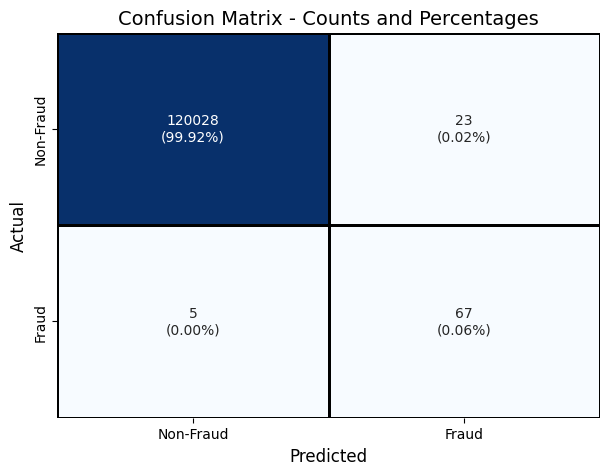

In [47]:

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)


# Plot confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(
    cm_percent,
    annot=labels,
    fmt='',
    cmap='Blues',
    xticklabels=['Non-Fraud', 'Fraud'],
    yticklabels=['Non-Fraud', 'Fraud'],
    linewidths=1,
    linecolor='black',
    cbar=False
)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix - Counts and Percentages', fontsize=14)
plt.show()


* Key Factors Predicting Fraud

List features most important for detecting fraud.

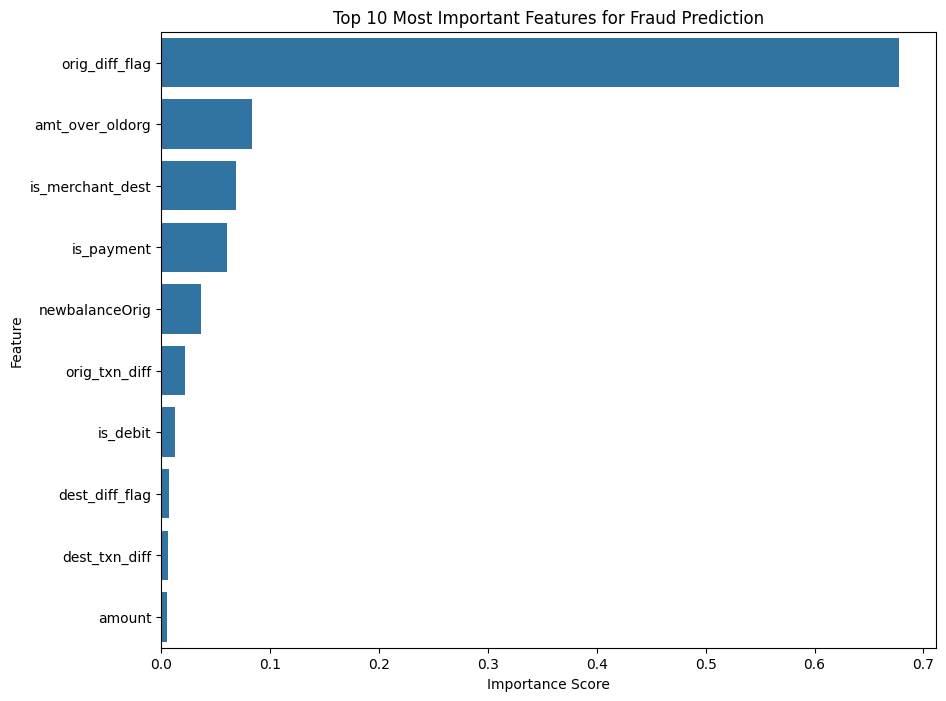

In [50]:

# Get feature importances from the trained model
importances = final_model.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10))
plt.title('Top 10 Most Important Features for Fraud Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

Large deviations from normal transactions: orig_diff_flag, orig_txn_diff, dest_diff_flag, dest_txn_diff

Unusually high amounts: amt_over_oldorg, amount

Unusual recipients or merchants: is_merchant_dest

Transaction type and balance changes: is_payment, is_debit, newbalanceOri


## Suggestions
Companies updating their systems should build fraud prevention directly into the design. This involves two main steps:

* Integrate real-time analysis: The new system needs to analyze every transaction instantly to catch fraud as it's happening.

* Set up smart rules: You should create a simple rule engine that works with your model to automatically flag or block suspicious transactions.

** To know if these changes are working, you should track key results: **

Check the money: The most important thing is to see a drop in financial losses from fraud.

Monitor your model: Look at its performance on new data. A good Recall score means it's catching fraud, and a good Precision score means it's not bothering customers with too many false alarms.

Listen to your customers: If user complaints about blocked transactions go down, it's a good sign the system is working well without disrupting the user experience.

Watch for new scams: A successful system must keep up with evolving fraud tactics.